In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# config
embeddingSize=512
numPoints=30 # number of points that we are going to receive to make a prediction about f given x and y
numVars=1 # the dimenstion of input points x
numYs=1 # the dimension of output points y = f(x)
blockSize = 60 # spatial extent of the model for its context
batchSize = 256
dataInfo = 'Mesh_XYSorted'

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk['EQ']+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList        
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            text += lines #json.loads(line)                
    return text

In [7]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TrainDatasetFixed\*.json'
files = glob.glob(path)
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
train_dataset = CharDataset(text, blockSize, chars) 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


data has 5000001 examples, 47 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([22, 42, 35, 38,  3, 42, 40, 41, 43,  3, 44, 12,  4,  4, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33])
id:1692743
inputs:<sin(sqrt(x1))______________________________________________
outputs:sin(sqrt(x1))>______________________________________________
points:tensor([[0.0000, 0.1000, 0.2100, 0.3100, 0.4100, 0.5200, 0.6200, 0.7200, 0.8300,
         0.9300, 1.0300, 1.1400, 1.2400, 1.3400, 1.4500, 1.5500, 1.6600, 1.7600,
         1.8600, 1.9700, 2.0700, 2.9000, 3.0000, 2.1700, 2.2800, 2.3800, 2.4800,
         2.5900, 2.6900, 2.7900],
        [0.0000, 0.3100, 0.4400, 0.5300, 0.6000, 0.6600, 0.7100, 0.7500, 0.7900,
         0.8200, 0.8500, 0.8800, 0.9000, 0.9200, 0.9300, 0.9500, 0.9600, 0.9700,
         0.9800, 0.9900, 0.9900, 0.9900, 0.9900, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000]])


In [9]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TestDataset\*.json'
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, chars)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.22it/s]

data has 1001 examples, 47 unique.


In [10]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
    
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

id:700
inputs:<0.73*sqrt(-x1**2)__________________________________________
outputs:0.73*sqrt(-x1**2)>__________________________________________
points:tensor([[0.0000, 0.1000, 0.2100, 0.3100, 0.4100, 0.5200, 0.6200, 0.7200, 0.8300,
         0.9300, 1.0300, 1.1400, 1.2400, 1.3400, 1.4500, 1.5500, 1.6600, 1.7600,
         1.8600, 1.9700, 2.0700, 2.1700, 2.2800, 2.3800, 2.4800, 2.5900, 2.6900,
         2.7900, 2.9000, 3.0000],
        [0.0000, 0.0700, 0.1500, 0.2300, 0.3000, 0.3800, 0.4600, 0.5300, 0.6100,
         0.6800, 0.7600, 0.8400, 0.9100, 0.9800, 1.0700, 1.1400, 1.2200, 1.2900,
         1.3700, 1.4500, 1.5200, 1.5900, 1.6700, 1.7500, 1.8200, 1.9000, 1.9800,
         2.0500, 2.1300, 2.2000]])


In [11]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/19/2021 13:44:59 - INFO - mingpt.model -   number of parameters: 3.055821e+07


In [ ]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=50, batch_size=batchSize, learning_rate=6e-7,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path='./SavedModels/bestModel/checkpoint.pt')
trainer = Trainer(model, train_dataset, test_dataset, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

epoch 1 iter 2219: train loss 0.24851. lr 5.952337e-07:  11%|██▏                | 2220/19532 [16:35<2:10:12,  2.22it/s]

Input:tensor([22, 42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 17, 18,  4, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0')
Logit:tensor([42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 17, 19,  4, 23, 23, 23, 23, 23,
        11, 23, 23, 23, 23, 23, 23, 11, 11, 11, 11, 11, 11, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 11, 23, 23, 23, 23, 23,
        23, 11, 23, 23, 23, 23], device='cuda:0')
Input:<sqrt(x1+0.67)______________________________________________
Logit:sqrt(x1+0.68)>>>>>0>>>>>>000000>>>>>>>>>>>>>>>>>0>>>>>>0>>>>
Target:tensor([42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 17, 18,  4, 23, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33,

epoch 1 iter 3054: train loss 0.24065. lr 5.909940e-07:  16%|██▉                | 3055/19532 [22:58<2:03:59,  2.21it/s]

Input:tensor([22, 42, 35, 38,  3, 44, 12,  4, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0')
Logit:tensor([42, 35, 38,  3, 44, 12,  4, 23, 11, 23, 11, 23, 23, 11, 11, 35,  5, 41,
        23, 11,  5, 41, 12, 44, 38, 44, 44,  5, 44, 44, 44, 44,  8, 44, 44, 11,
         8, 44, 12,  5, 44,  8, 44,  6, 44,  6, 44, 23, 23, 44, 11, 11, 44, 44,
        12, 12, 44, 11, 11,  8], device='cuda:0')
Input:<sin(x1)____________________________________________________
Logit:sin(x1)>0>0>>00i*r>0*r1xnxx*xxxx-xx0-x1*x-x+x+x>>x00xx11x00-
Target:tensor([42, 35, 38,  3, 44, 12,  4, 23, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33,

epoch 1 iter 3275: train loss 0.24068. lr 5.896513e-07:  17%|███▏               | 3276/19532 [24:39<2:12:03,  2.05it/s]

Input:tensor([22, 11,  9, 13, 16,  5, 44, 12,  6, 11,  9, 19, 16,  5, 42, 40, 41, 43,
         3, 11,  9, 20, 12,  5, 44, 12,  8, 12,  4, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0')
Logit:tensor([11,  9, 19, 18,  5, 44, 12,  6, 11,  9, 19, 15,  5, 42, 40, 41, 43,  3,
        12,  9, 20,  5,  5, 44, 12,  8, 12,  4, 23, 11, 11, 23, 12, 11, 11, 11,
        11, 11, 23, 23, 11, 23, 11, 11, 23, 23, 11, 23, 11, 23, 23, 23, 11, 23,
        23, 11, 11, 11, 11, 11], device='cuda:0')
Input:<0.25*x1+0.85*sqrt(0.91*x1-1)_______________________________
Logit:0.87*x1+0.84*sqrt(1.9**x1-1)>00>100000>>0>00>>0>0>>>0>>00000
Target:tensor([11,  9, 13, 16,  5, 44, 12,  6, 11,  9, 19, 16,  5, 42, 40, 41, 43,  3,
        11,  9, 20, 12,  5, 44, 12,  8, 12,  4, 23, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33,

epoch 1 iter 3359: train loss 0.25407. lr 5.891170e-07:  17%|███▎               | 3360/19532 [25:18<2:00:42,  2.23it/s]

Input:tensor([22, 11,  9, 14, 15,  5, 44, 12,  6, 11,  9, 19, 14, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0')
Logit:tensor([11,  9, 14, 14,  5, 44, 12,  6, 11,  9, 19, 12, 23, 23, 23, 11, 23, 11,
        23, 11,  8, 23, 11, 23, 23, 23, 11, 23, 23, 23, 23, 11,  8, 44, 23, 23,
        44, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 18, 23, 23,
        23, 23, 23, 23, 23, 23], device='cuda:0')
Input:<0.34*x1+0.83_______________________________________________
Logit:0.33*x1+0.81>>>0>0>0->0>>>0>>>>0-x>>x>>>>>>>>>>>>>>7>>>>>>>>
Target:tensor([11,  9, 14, 15,  5, 44, 12,  6, 11,  9, 19, 14, 23, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33,

epoch 1 iter 3463: train loss 0.28494. lr 5.884372e-07:  18%|███▎               | 3464/19532 [26:05<2:01:32,  2.20it/s]

Input:tensor([22, 11,  9, 16, 17,  5, 42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 14, 13,
         4, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0')
Logit:tensor([11,  9, 16, 14,  5, 42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 14, 14,  4,
        23, 23, 23, 23, 11, 23, 23, 11, 23, 11,  8, 11,  8, 11, 23, 11, 23, 23,
        11, 23, 23, 23, 23, 23, 11, 23, 23, 23, 23, 23, 23, 23, 23, 23, 11, 23,
        23, 23, 23, 11, 23, 23], device='cuda:0')
Input:<0.56*sqrt(x1+0.32)_________________________________________
Logit:0.53*sqrt(x1+0.33)>>>>0>>0>0-0-0>0>>0>>>>>0>>>>>>>>>0>>>>0>>
Target:tensor([11,  9, 16, 17,  5, 42, 40, 41, 43,  3, 44, 12,  6, 11,  9, 14, 13,  4,
        23, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33,

epoch 1 iter 3492: train loss 0.23203. lr 5.882440e-07:  18%|███▍               | 3493/19532 [26:18<2:02:10,  2.19it/s]

In [14]:
# model.load_state_dict(torch.load('./SavedModels/bestModel/checkpoint.pt'))
# model = model.eval().to(trainer.device)

In [27]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [28]:
fName = '{}_SymbolicGPT_{}_{}_{}.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [29]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
#from gp_model import Genetic_Model
#from mlp_model import MLP_Model
    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

# gpm = Genetic_Model(n_jobs=-1)
# mlp = MLP_Model()

resultDict = {}
with open(fName, 'w', encoding="utf-8") as o:
    modelName = 'SymbolicGPT'
    resultDict[fName] = {modelName:[]}
    
    for i, batch in enumerate(loader):
        inputs,outputs,points = batch
        
        print('Test Case {}.'.format(i))
        o.write('Test Case {}/{}.\n'.format(i,len(textTest)))
        
        t = json.loads(textTest[i])
        
        inputs = inputs[:,0:1].to(trainer.device)
        points = points.to(trainer.device)
        outputsHat = sample(model, inputs, blockSize, points=points,
                      temperature=1.0, sample=True, 
                      top_k=10)[0]
            
        # filter out predicted
        target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
        predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])
        
        #print(target, predicted)
        #raise

        target = target.strip(train_dataset.paddingToken).split('>')
        target = target[0] if len(target[0])>1 else target[1]
        target = target.strip('<').strip(">")
        predicted = predicted.strip(train_dataset.paddingToken).split('>')
        predicted = predicted[0] if len(predicted[0])>1 else predicted[1]
        predicted = predicted.strip('<').strip(">")
       
        o.write('{}\n'.format(target))
        
        print('Target:{}\nPredicted:{}'.format(target, predicted))
        
        Ys = [] #t['YT']
        Yhats = []
        for xs in t['XT']:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 100 if np.isinf(YEval) else YEval
            except:
                YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 100 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 100
            Yhats.append(Yhat)
        mseErr = mse(Ys,Yhats)
        
        if type(mseErr) is np.complex128:
            mseErr = abs(mseErr.real)
            
        resultDict[fName][modelName].append(mseErr)
        
        o.write('{}:{}\n{}\n\n'.format(modelName, 
                               mseErr,
                               predicted))
        
        print('MSE:{}\n'.format(mseErr))
print('Avg MSE:{}'.format(np.mean(resultDict[fName][modelName])))

Test Case 0.
Target:-sin(1.1*x1+0.64)
Predicted:-sin(1.12*x1+0.6)
MSE:0.00179218506524786

Test Case 1.
Target:-1.42*x1+sqrt(x1+0.53)
Predicted:-0.07*x1**2-0.76*x1+0.74
MSE:0.03163075464969516

Test Case 2.
Target:sqrt(-sin(0.2*x1))
Predicted:sqrt(sin(0.22*x1))
MSE:0.0007840735499230945

Test Case 3.
Target:sin(sqrt(x1))
Predicted:sin(sqrt(x1))
MSE:0.0

Test Case 4.
Target:0.86*x1**2-0.59*x1+1.36
Predicted:0.88*x1**2-0.77*x1+sqrt(x1+0.79)+0.39
MSE:0.9257718690292271

Test Case 5.
Target:0.28*sqrt(-x1**2)
Predicted:0.26*x1+0.02
MSE:0.005340666666666676

Test Case 6.
Target:sin(0.07*x1**2+0.28*x1)
Predicted:-0.1*x1**2+0.56*x1+0.03*sqrt(-x1-0.3)
MSE:0.14874999066618227

Test Case 7.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 8.
Target:0.81*sqrt(-x1**2-0.95*x1+0.12)
Predicted:0.85*sqrt(0.75*x1**2+x1-0.12)
MSE:0.06403654980872284

Test Case 9.
Target:sin(x1+0.37)
Predicted:sin(x1+0.38)
MSE:4.785347829489808e-05

Test Case 10.
Target:-0.68*x1**2+1.77*x1
Predi

Target:x1-0.21
Predicted:0.95*x1-0.17
MSE:0.037029166666666745

Test Case 88.
Target:0.33*x1-0.98
Predicted:0.64*x1**2-1.14*x1+0.5
MSE:86.985542468

Test Case 89.
Target:sqrt(x1-0.1)
Predicted:sqrt(x1-0.11)
MSE:5.8533811790121585e-06

Test Case 90.
Target:1.42*x1+0.77
Predicted:0.8*x1**2+1.04*x1-0.25
MSE:243.66957853333335

Test Case 91.
Target:sin(0.34*x1)
Predicted:sin(0.35*x1+0.03)
MSE:0.0005035108699386491

Test Case 92.
Target:0.83*sqrt(-x1)
Predicted:0.81*sqrt(x1)
MSE:0.0018199999999999833

Test Case 93.
Target:sin(x1)+sin(x1-0.38)
Predicted:sin(x1)+sin(0.98*x1-0.33)
MSE:0.0006135557603863494

Test Case 94.
Target:0.94*sqrt(-0.65*x1-1)
Predicted:0.91*sqrt(-0.6*x1-1)
MSE:0.012659954162339166

Test Case 95.
Target:-2*x1*sin(0.58*x1)+1.0
Predicted:2*x1-0.58*sin(0.61*x1-0.03)
MSE:124.38909711226566

Test Case 96.
Target:sin(sqrt(x1+0.02))
Predicted:sin(sqrt(x1+0.03))
MSE:1.5075313947297777e-06

Test Case 97.
Target:x1**(1/4)
Predicted:0.96*(-x1)**(1/4)
MSE:0.7593589215730575

Test Ca

Target:sin(0.6*sqrt(x1))
Predicted:sin(0.59*sqrt(-x1))
MSE:4.105946186030381e-05

Test Case 174.
Target:sin(0.76*x1-0.31)
Predicted:sin(0.74*x1-0.27)
MSE:0.0019076004626620746

Test Case 175.
Target:x1**(1/4)
Predicted:0.97*x1**(1/4)
MSE:0.0019108976539042963

Test Case 176.
Target:1.02*x1+1.36
Predicted:1.21*x1-sin(0.29*x1-0.21)+1.17
MSE:0.04088510184849629

Test Case 177.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 178.
Target:-sin(0.65*x1**2-0.13*x1)
Predicted:-sin(0.67*x1**2-0.1*x1-0.02)
MSE:0.16233924267727454

Test Case 179.
Target:-sin(0.4*x1)
Predicted:-sin(0.36*x1-0.03)
MSE:0.0066784066019260025

Test Case 180.
Target:x1**2+1.17*x1-0.12
Predicted:0.97*x1**2+1.11*x1-0.09
MSE:0.8694479970000024

Test Case 181.
Target:2.25*x1-0.82
Predicted:2*x1+sin(0.14*x1)-0.76
MSE:0.2515099715591449

Test Case 182.
Target:0.77*sqrt(0.35*x1+1)+sin(x1-0.89)
Predicted:0.88*sqrt(0.41*x1+1)+sin(x1-0.99)
MSE:0.09594678967767717

Test Case 183.
Target:0.29*x1**2-0.24*x

Target:0.33*sqrt(x1)*sqrt(-x1)
Predicted:0.32*x1+0.03
MSE:0.0003151666666666665

Test Case 261.
Target:2*x1**(3/2)-0.61
Predicted:-0.56*sqrt(x1)+2*x1
MSE:139.74105697644663

Test Case 262.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 263.
Target:sin(0.33*x1**2-0.35*x1)
Predicted:sin(0.32*x1**2-0.34*x1+0.02)
MSE:0.015094889393846537

Test Case 264.
Target:sqrt(x1**2+0.27*x1)
Predicted:sqrt(x1**2+0.23*x1)
MSE:0.0003784484991617042

Test Case 265.
Target:0.33*x1**2-0.86*x1
Predicted:0.34*x1**2-0.82*x1+0.03
MSE:0.19481766633333378

Test Case 266.
Target:x1+0.78*sin(x1+0.73)
Predicted:0.95*x1+0.77*sin(x1+0.71)
MSE:0.05480106429369222

Test Case 267.
Target:-sin(sin(0.49*x1))
Predicted:-sin(sin(0.47*x1-0.03))
MSE:0.005021262341133535

Test Case 268.
Target:sqrt(x1)+x1**2-0.31*x1
Predicted:sqrt(x1)+x1**2-0.37*x1+0.02
MSE:0.06670599999999999

Test Case 269.
Target:sin(0.12*x1**2)
Predicted:sin(0.12*x1**2+0.02)
MSE:0.00017708270387586556

Test Case 270.
Target:sqr

Target:x1
Predicted:x1+0.02
MSE:0.0003999999999999885

Test Case 347.
Target:-0.77*x1**2+0.69*x1
Predicted:-0.74*x1**2+0.69*x1+0.03
MSE:0.5099069970000021

Test Case 348.
Target:1.64*x1+sqrt(x1+0.71)
Predicted:1.55*x1+sqrt(x1+0.78)-0.05
MSE:0.2035226498751301

Test Case 349.
Target:0.2*sqrt(-x1**2)
Predicted:0.19*x1+0.02
MSE:0.000725166666666669

Test Case 350.
Target:-0.15*x1**2+0.1*x1
Predicted:-0.42*x1**2-0.29*x1-0.09
MSE:64.726151757

Test Case 351.
Target:0.21*x1**2-0.52*x1+0.29
Predicted:sin(0.23*x1**2-0.54*x1+0.31)
MSE:8.859253812177526

Test Case 352.
Target:sin(x1)*sin(x1-0.98)
Predicted:sin(0.97*x1-0.91)*sin(x1-0.03)
MSE:0.0013590311818282926

Test Case 353.
Target:0.78*x1**2
Predicted:0.75*x1**2-0.01*x1+0.02
MSE:0.508030663666668

Test Case 354.
Target:0.82*(x1-0.13)**(1/4)
Predicted:0.82*(0.13-x1)**(1/4)
MSE:0.5826788958452838

Test Case 355.
Target:0.68*sqrt(x1)*sqrt(0.31*x1-1)
Predicted:0.65*sqrt(-x1)*sqrt(1-0.31*x1)
MSE:0.0018988050000000023

Test Case 356.
Target:0.43-0

Target:x1
Predicted:x1+0.03
MSE:0.0009000000000000072

Test Case 433.
Target:sin(0.42*x1**2+0.11*x1)
Predicted:sin(0.42*x1**2+0.1*x1+0.02)
MSE:0.0003770120650635897

Test Case 434.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 435.
Target:2*x1-1.34
Predicted:2*x1-1.25
MSE:0.00809999999999997

Test Case 436.
Target:x1*sin(x1)-0.36
Predicted:x1-0.35*sin(x1-0.03)
MSE:72.47664915427121

Test Case 437.
Target:sin(0.63*x1**2+0.48*x1+0.09)
Predicted:sin(0.63*x1**2+0.5*x1+0.12)
MSE:0.00758375850314568

Test Case 438.
Target:sqrt(x1-0.7)-sin(0.45*x1)
Predicted:sqrt(x1-0.74)-sin(0.38*x1)
MSE:0.029459947839990824

Test Case 439.
Target:0.96*x1**2-1.2*x1+sin(0.3*x1+0.38)+0.28
Predicted:0.9*x1**2-0.86*x1+0.64
MSE:0.1284165495662983

Test Case 440.
Target:x1**2+0.3*x1
Predicted:x1**2+0.28*x1+0.03
MSE:0.004020666666666553

Test Case 441.
Target:-0.04*x1+sin(x1)+0.17
Predicted:sin(0.04*x1+0.19)+sin(x1+0.08)
MSE:0.150752344181718

Test Case 442.
Target:sin(sin(0.58*x1+0.49

Target:0.72*sqrt(x1+0.08)+sin(0.86*x1+0.37)
Predicted:0.66*sqrt(x1+0.17)+sin(0.87*x1+0.34)
MSE:0.013154297280688466

Test Case 519.
Target:0.98*sqrt(x1+0.03)
Predicted:sqrt(x1+0.04)
MSE:0.002037547149477667

Test Case 520.
Target:sin(0.8*x1-0.2)
Predicted:sin(0.8*x1-0.17)
MSE:0.0005526413505648597

Test Case 521.
Target:sin(0.69*x1)
Predicted:sin(0.66*x1+0.03)
MSE:0.008745763794978762

Test Case 522.
Target:sqrt(x1+0.22)
Predicted:sqrt(-1.0*x1-0.24)
MSE:2.164997480566725e-05

Test Case 523.
Target:-0.15*x1**2+0.02*x1
Predicted:-0.15*x1**2+0.02*x1+0.03
MSE:0.0008999999999999983

Test Case 524.
Target:0.52*x1**2+0.82*x1
Predicted:-0.69*x1**2*sin(0.12*x1-0.11)+0.48*x1-0.13
MSE:448.9193288508703

Test Case 525.
Target:-0.53*x1
Predicted:-0.31*x1-sin(0.26*x1)+0.03
MSE:0.028310909662051676

Test Case 526.
Target:sqrt(x1)
Predicted:0.97*sqrt(-x1)
MSE:0.004095000000000004

Test Case 527.
Target:-sin(0.12*x1-0.3)
Predicted:-sin(0.12*x1-0.33)
MSE:0.0008441246388437288

Test Case 528.
Target:0.66

Target:-0.32*x1+sin(x1+0.32)-0.74
Predicted:-0.4*x1+sin(x1+0.32)-0.69
MSE:0.10339066666666662

Test Case 604.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 605.
Target:sqrt(x1-0.3)*sin(x1)
Predicted:0.96*sqrt(x1-0.33)*sin(x1+0.04)
MSE:0.007977216307278429

Test Case 606.
Target:0.37*x1**2-0.05*x1-0.13*sin(x1)
Predicted:0.31*x1**2*sin(x1-0.08)+0.11*x1-0.16
MSE:172.03538261551896

Test Case 607.
Target:sqrt(sin(0.3*x1-0.13))
Predicted:sqrt(sin(0.29*x1-0.13))
MSE:7.374296902439153e-05

Test Case 608.
Target:0.36*x1-0.86
Predicted:0.38*x1**2-1.0*x1+0.62
MSE:15.220764852000002

Test Case 609.
Target:2.19*x1-0.08
Predicted:2*x1-0.04
MSE:0.7068451666666654

Test Case 610.
Target:0.11*x1**2+0.54*x1+sqrt(x1-0.33)
Predicted:0.11*x1**2+0.36*x1+sqrt(x1-0.32)
MSE:0.6910708603105048

Test Case 611.
Target:sqrt(sin(x1+0.98))
Predicted:sqrt(sin(x1+0.96))
MSE:0.00047614260711649606

Test Case 612.
Target:2.9*x1+0.07
Predicted:2.77*x1+0.08
MSE:0.3508031666666669

Test Case 

Target:sin(1.62*x1+0.08)
Predicted:sin(1.59*x1+0.1)
MSE:0.00833935139228521

Test Case 691.
Target:2*sqrt(x1)
Predicted:2*sqrt(x1)
MSE:0.0

Test Case 692.
Target:0.56*sqrt(x1)
Predicted:0.57*sqrt(-x1)
MSE:0.00045499999999999013

Test Case 693.
Target:0.03*x1+0.68
Predicted:0.68*x1**2-0.15*x1-0.07
MSE:196.7206884586667

Test Case 694.
Target:0.73*sqrt(x1+0.22)
Predicted:0.71*sqrt(x1+0.24)
MSE:0.0016352211819417733

Test Case 695.
Target:x1**2+x1-0.37
Predicted:x1**2+0.96*x1-0.34
MSE:0.024302666666667062

Test Case 696.
Target:sin(sin(x1-0.59))
Predicted:sin(sin(x1-0.56))
MSE:0.0003572015307011461

Test Case 697.
Target:-0.53*x1**3-0.82*x1**2+0.74*x1
Predicted:x.2.4.2.343-1..4.x.5x1.-x.0.-30.5+3.0.43.1.x-44.x1.0.0.xx0.0
MSE:30002.063608316457

Test Case 698.
Target:sqrt(x1)+0.38*x1**2+0.26*x1+0.02
Predicted:sqrt(x1)+0.34*x1**2+0.29*x1+0.05
MSE:0.562554494666665

Test Case 699.
Target:0.54*x1
Predicted:0.83*x1**2-0.29*x1+0.03
MSE:231.8078073703333

Test Case 700.
Target:sqrt(x1+0.13)+sin(

Target:0.74*x1**3
Predicted:0.81*x1**2+0.15
MSE:4782.371050327466

Test Case 777.
Target:sin(sin(x1))
Predicted:sin(sin(x1+0.02))
MSE:0.0001471142642799757

Test Case 778.
Target:1.84*x1*sqrt(x1-0.8)+1.14
Predicted:1.76*x1+0.98*sqrt(x1-0.85)
MSE:69.8769960707269

Test Case 779.
Target:-0.25*x1**2+1.87*x1+0.04
Predicted:x1+sin(0.76*x1+0.35)-0.25
MSE:1.0454996804753376

Test Case 780.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0.0

Test Case 781.
Target:0.09*x1-0.21*sin(0.85*x1)
Predicted:0.12*x1**2-0.33*x1+0.04*sqrt(x1+0.3)
MSE:0.6716308887496693

Test Case 782.
Target:x1**2+x1+0.76
Predicted:x1**2+0.6*x1+0.85*sqrt(-0.77*x1-1)-0.05
MSE:0.7358508991719305

Test Case 783.
Target:-0.08*x1**2+0.93*x1-0.58
Predicted:-0.07*x1**2+0.91*x1-0.52
MSE:0.037499666333333244

Test Case 784.
Target:sin(x1-0.89)*sin(x1+0.95)
Predicted:sin(x1-0.84)*sin(x1+0.9)
MSE:0.002379801951578788

Test Case 785.
Target:-0.81*x1**2-0.08
Predicted:-0.85*x1**2-0.06*x1+0.03
MSE:1.1779753279999972

Test Case 786.
Target:0.04

Target:sin(sin(0.62*x1))
Predicted:sin(sin(0.6*x1+0.03))
MSE:0.0028993257758077313

Test Case 864.
Target:sqrt(2)*sqrt(x1+0.34)
Predicted:sqrt(2)*sqrt(x1+0.33)
MSE:1.0576194010883119e-05

Test Case 865.
Target:0.42-0.93*x1
Predicted:0.43-0.9*x1
MSE:0.022136500000000062

Test Case 866.
Target:0.27*x1+0.38
Predicted:0.37*x1+0.39
MSE:0.22371666666666667

Test Case 867.
Target:-sin(sin(0.63*x1))
Predicted:-sin(sin(0.63*x1-0.03))
MSE:0.0005345891931017405

Test Case 868.
Target:0.59*x1+sin(x1)-0.6
Predicted:0.93*x1+sin(x1+0.25)-0.77
MSE:2.0959212180131916

Test Case 869.
Target:-sin(0.4*x1-0.71)
Predicted:-sin(0.38*x1-0.71)
MSE:0.0017289210531399742

Test Case 870.
Target:sin(0.27*sqrt(-x1))
Predicted:sqrt(sin(0.08*x1))
MSE:0.0027594286025373173

Test Case 871.
Target:-0.4*x1**2*sin(0.45*x1)
Predicted:-0.22*x1**2*sqrt(x1-0.19)-0.07*x1+0.05
MSE:31.251403364091956

Test Case 872.
Target:0.09*x1-0.81
Predicted:0.09*x1-0.77
MSE:0.0016000000000000038

Test Case 873.
Target:1.16*x1**2+0.29
Predic

Target:0.69*x1**2-0.66*x1
Predicted:-0.76*x1**2+0.74*x1+0.12
MSE:711.0605796583334

Test Case 950.
Target:0.95*sqrt(x1)+0.43*x1-0.75
Predicted:sqrt(x1)+0.33*x1-0.67
MSE:0.07810007198119448

Test Case 951.
Target:x1-0.65
Predicted:0.94*x1-0.59
MSE:0.04806599999999996

Test Case 952.
Target:x1
Predicted:x1+0.03
MSE:0.0009000000000000072

Test Case 953.
Target:sin(sin(x1))
Predicted:sin(sin(x1+0.02))
MSE:0.0001471142642799757

Test Case 954.
Target:2*x1-1.72
Predicted:2*x1-1.58
MSE:0.01960000000000001

Test Case 955.
Target:sqrt(2)*sqrt(x1)
Predicted:sqrt(2)*sqrt(x1)
MSE:0.0

Test Case 956.
Target:1.3*x1+0.26*sqrt(-x1)-0.24
Predicted:x1+0.77*sqrt(x1+0.44)-0.77
MSE:0.5645902245731192

Test Case 957.
Target:sin(x1)
Predicted:sin(x1+0.02)
MSE:0.00019100423851277883

Test Case 958.
Target:2*x1-0.27
Predicted:1.86*x1-0.23
MSE:0.3710926666666669

Test Case 959.
Target:sin(x1)
Predicted:sin(x1+0.03)
MSE:0.00042967902001861315

Test Case 960.
Target:0.33*sqrt(0.36*x1**2-x1)
Predicted:0.36*sqrt(0.

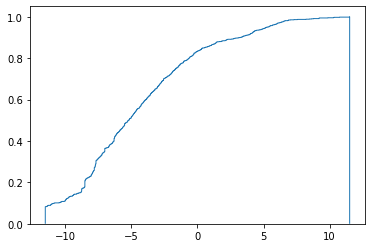

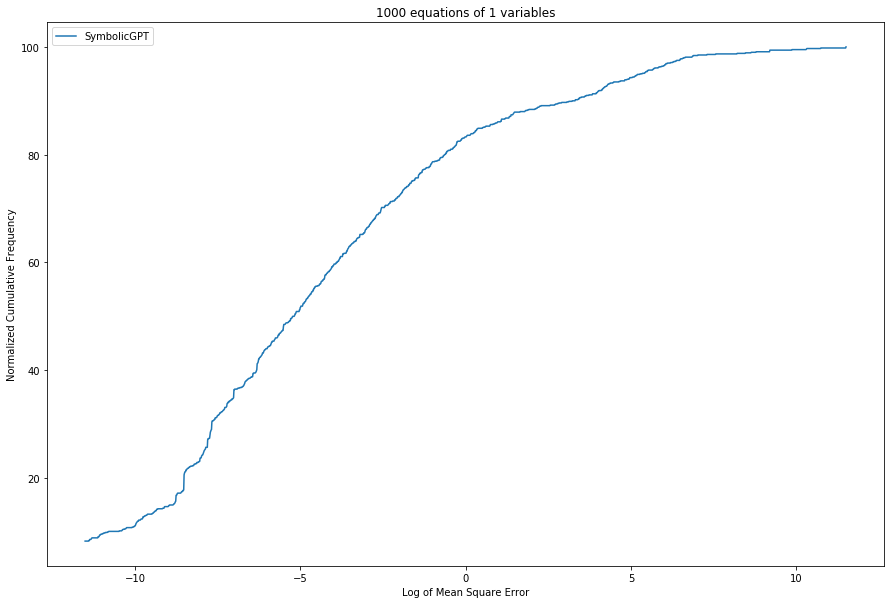

In [30]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(resultDict[fName].keys())
lists_of_error_scores = [resultDict[fName][key] for key in models]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density="true")
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName)
plt.savefig(name)